**Economic Motivation & Predictor Choice**

We want to nowcast U.S. GDP growth using a simple ARIMAX model.

GDP is defined by the national accounts identity:
GDP = C + I + G + NX

(This formula comes from the U.S. Bureau of Economic Analysis and standard macro textbooks such as Mankiw, Macroeconomics.)

To keep the model simple and meaningful, we select indicators that represent the most important and most cyclical parts of GDP:

Industrial Production (INDPRO) -> production & investment (Used in classic business cycle research; Stock & Watson, 1999).</br>
Retail Sales (RSXFS) -> consumption (Consumption drives most of GDP; Giannone, Reichlin & Small, 2008).</br>
Initial Unemployment Claims (ICSA) -> labor income (Job losses affect household spending; Blanchard & Katz, 1992).</br>

These three indicators capture production, consumption, and labor-market conditions — the main engines behind short-run GDP movements.
They are also high-frequency, timely, and not highly correlated, making them ideal for a simple ARIMAX model.

**Workflow Overview**

-Download data from FRED. </br>
-Convert everything to quarterly data.</br>
-Compute growth rates (log-differences).</br>
-Check correlations and VIF.</br>
-Fit Naive, ARIMA(1,1,1), and ARIMAX(1,1,1).</br>
-Compare errors (MAE).</br>
-Produce next-quarter GDP forecast.</br>
-Plot results.


===== Variance Inflation Factors (VIF) =====
        variable       VIF
0  indpro_growth  2.426437
1   rsxfs_growth  1.669008
2    icsa_growth  1.920007

====== ARIMA(1,1,1) – no exogenous variables ======
                               SARIMAX Results                                
Dep. Variable:             gdp_growth   No. Observations:                  133
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -202.195
Date:                Wed, 26 Nov 2025   AIC                            410.391
Time:                        21:02:48   BIC                            418.993
Sample:                    06-30-1992   HQIC                           413.886
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

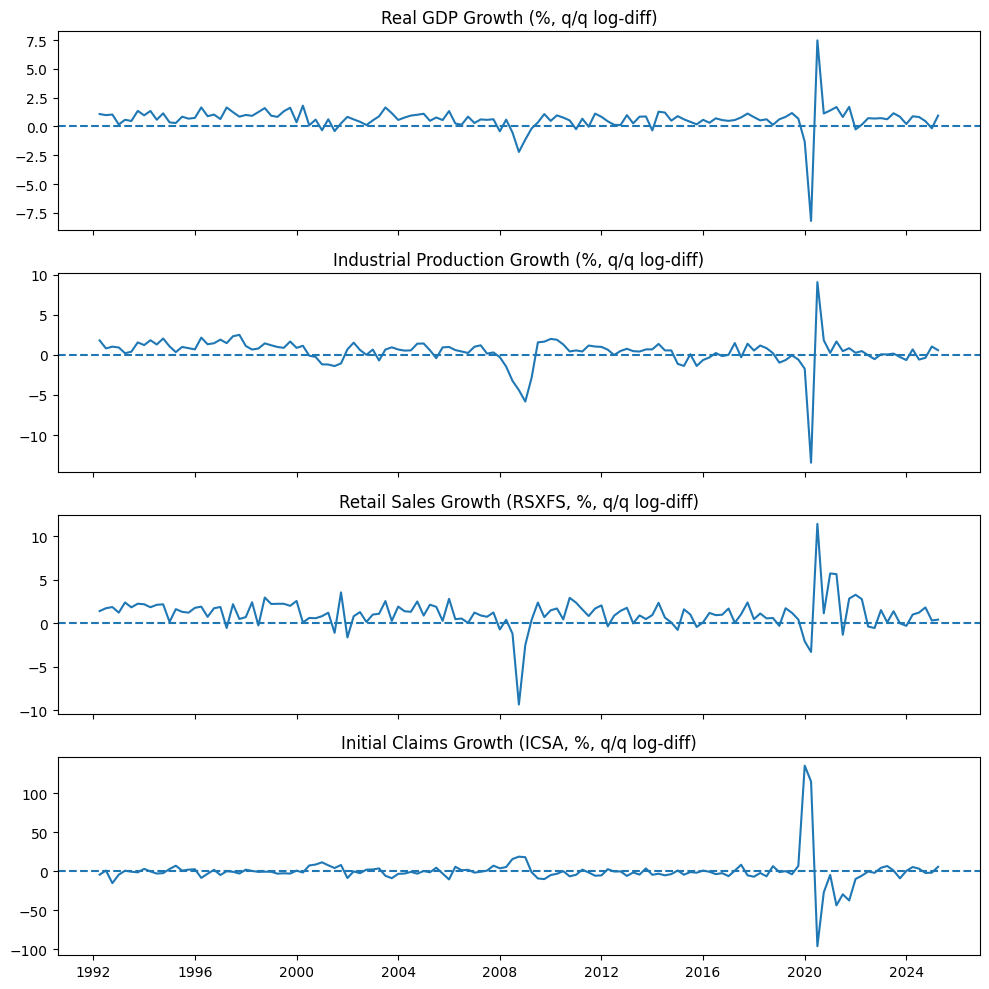

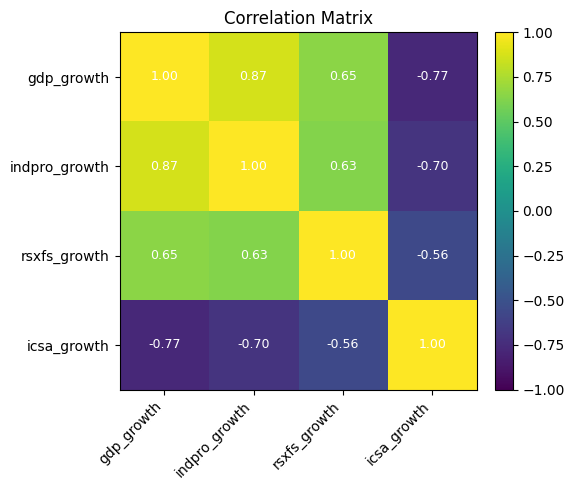

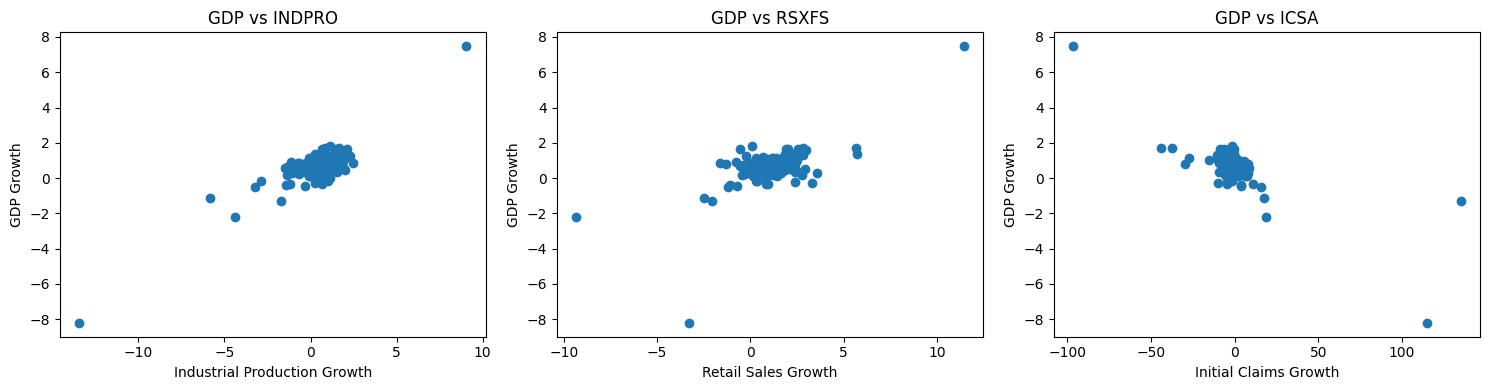

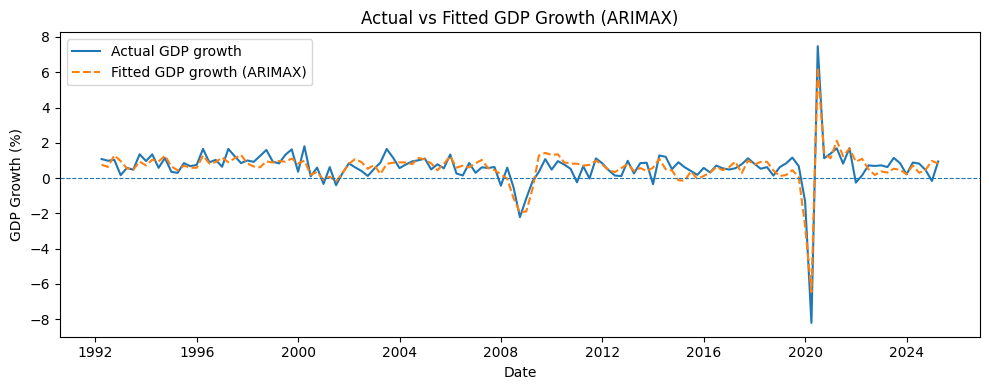

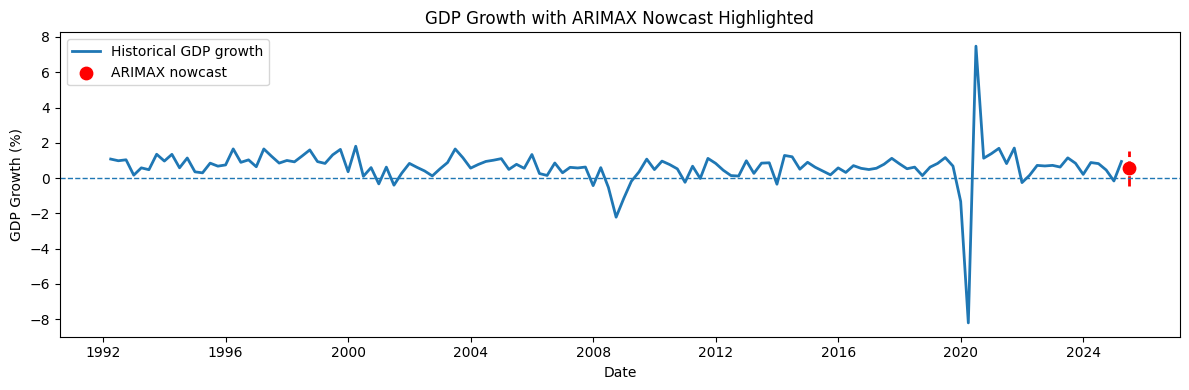

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =====================================================
# 1. Load FRED series
# =====================================================
BASE_URL = "https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"

def load_fred(series_id):
    """
    Loads a FRED CSV directly from the URL.
    Handles either DATE or observation_date as the date column.
    Returns a DataFrame with:
        index: DatetimeIndex
        column: series_id (numeric)
    """
    url = BASE_URL.format(series_id=series_id)
    df = pd.read_csv(url)

    # FRED sometimes uses DATE, sometimes observation_date
    if "DATE" in df.columns:
        date_col = "DATE"
    else:
        date_col = "observation_date"

    df[date_col] = pd.to_datetime(df[date_col])
    df = df.rename(columns={date_col: "date"})
    df = df.set_index("date").sort_index()

    # force numeric, turn "." into NaN etc.
    df[series_id] = pd.to_numeric(df[series_id], errors="coerce")

    return df[[series_id]]

# =====================================================
# 2. Download the series
# =====================================================
# Target: Real GDP (quarterly)
gdp = load_fred("GDPC1")

# Exogenous predictors (monthly/weekly)
indpro = load_fred("INDPRO")   # Industrial Production
rsxfs  = load_fred("RSXFS")    # Advance Retail Sales: Retail Trade
icsa   = load_fred("ICSA")     # Initial Claims

# =====================================================
# 3. Convert everything to quarterly
# =====================================================
# GDP: already quarterly
gdp_q = gdp.copy()
gdp_q["period"] = gdp_q.index.to_period("Q")
gdp_q = gdp_q.groupby("period")["GDPC1"].last()

def to_quarterly_mean(df, col):
    temp = df.copy()
    temp["period"] = temp.index.to_period("Q")
    return temp.groupby("period")[col].mean()

indpro_q = to_quarterly_mean(indpro, "INDPRO")
rsxfs_q  = to_quarterly_mean(rsxfs,  "RSXFS")
icsa_q   = to_quarterly_mean(icsa,   "ICSA")

# =====================================================
# 4. Merge into one quarterly DataFrame
# =====================================================
data_q = pd.concat(
    [gdp_q, indpro_q, rsxfs_q, icsa_q],
    axis=1,
    join="inner"
)
data_q.columns = ["gdp_level", "indpro_level", "rsxfs_level", "icsa_level"]
data_q = data_q.dropna()

# =====================================================
# 5. Make growth rates (log-diffs, in %) and see VIF
# =====================================================
df = pd.DataFrame(index=data_q.index)

df["gdp_growth"]    = 100 * np.log(data_q["gdp_level"]).diff()
df["indpro_growth"] = 100 * np.log(data_q["indpro_level"]).diff()
df["rsxfs_growth"]  = 100 * np.log(data_q["rsxfs_level"]).diff()
df["icsa_growth"]   = 100 * np.log(data_q["icsa_level"]).diff()

df = df.dropna()  # drop first NA from differencing

y = df["gdp_growth"]
X = df[["indpro_growth", "rsxfs_growth", "icsa_growth"]]

# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data["variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n===== Variance Inflation Factors (VIF) =====")
print(vif_data)

# =====================================================
# 6. Fit ARIMA and ARIMAX on full data
# =====================================================
# ARIMA baseline (no exogenous variables)
model_arima_full = sm.tsa.SARIMAX(
    y,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_arima_full = model_arima_full.fit(disp=False)
print("\n====== ARIMA(1,1,1) – no exogenous variables ======")
print(results_arima_full.summary())

# ARIMAX model (with exogenous predictors)
model_arimax_full = sm.tsa.SARIMAX(
    y,
    exog=X,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_arimax_full = model_arimax_full.fit(disp=False)
print("\n====== ARIMAX(1,1,1) – with exogenous variables ======")
print(results_arimax_full.summary())

# =====================================================
# 7. One-step-ahead forecast (ARIMA vs ARIMAX)
# =====================================================
X_next = X.iloc[[-1]]  # last row as 1-row DataFrame for ARIMAX

# ARIMA forecast (no exog)
forecast_arima = results_arima_full.get_forecast(steps=1)
mean_forecast_arima = forecast_arima.predicted_mean.iloc[0]
conf_int_arima = forecast_arima.conf_int().iloc[0]

# ARIMAX forecast (with exog)
forecast_arimax = results_arimax_full.get_forecast(steps=1, exog=X_next)
mean_forecast_arimax = forecast_arimax.predicted_mean.iloc[0]
conf_int_arimax = forecast_arimax.conf_int().iloc[0]

print("\n====== One-step-ahead GDP growth forecast ======")
print(f"ARIMA  point forecast: {mean_forecast_arima:.3f} %")
print("ARIMA  95% CI:")
print(conf_int_arima)

print(f"\nARIMAX point forecast: {mean_forecast_arimax:.3f} %")
print("ARIMAX 95% CI:")
print(conf_int_arimax)

# =====================================================
# 8. Evaluation: Naive vs ARIMA vs ARIMAX (MAE)
# =====================================================
# simple train-test split: last 20 quarters as test
split = -20
y_train, y_test = y.iloc[:split], y.iloc[split:]
X_train, X_test = X.iloc[:split], X.iloc[split:]

# Naive baseline: next quarter = previous quarter
naive_pred = y_test.shift(1)           # previous observed value
naive_pred.iloc[0] = y_train.iloc[-1]  # first test value = last train value

# ARIMA baseline (train/test)
model_arima_tt = sm.tsa.SARIMAX(
    y_train,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_arima_tt = model_arima_tt.fit(disp=False)
pred_arima_tt = res_arima_tt.get_forecast(steps=len(y_test)).predicted_mean

# ARIMAX (train/test)
model_arimax_tt = sm.tsa.SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_arimax_tt = model_arimax_tt.fit(disp=False)
pred_arimax_tt = res_arimax_tt.get_forecast(
    steps=len(y_test),
    exog=X_test
).predicted_mean

mae_naive  = mean_absolute_error(y_test, naive_pred)
mae_arima  = mean_absolute_error(y_test, pred_arima_tt)
mae_arimax = mean_absolute_error(y_test, pred_arimax_tt)

print("\n====== MAE comparison (test set) ======")
print(f"MAE naive:   {mae_naive:.3f} percentage points")
print(f"MAE ARIMA:   {mae_arima:.3f} percentage points")
print(f"MAE ARIMAX:  {mae_arimax:.3f} percentage points")

# =====================================================
# 9. PLOTS
# =====================================================

# 9.1 Time series: GDP growth and predictors
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axes[0].plot(df.index.to_timestamp(), df["gdp_growth"])
axes[0].set_title("Real GDP Growth (%, q/q log-diff)")
axes[0].axhline(0, linestyle="--")

axes[1].plot(df.index.to_timestamp(), df["indpro_growth"])
axes[1].set_title("Industrial Production Growth (%, q/q log-diff)")
axes[1].axhline(0, linestyle="--")

axes[2].plot(df.index.to_timestamp(), df["rsxfs_growth"])
axes[2].set_title("Retail Sales Growth (RSXFS, %, q/q log-diff)")
axes[2].axhline(0, linestyle="--")

axes[3].plot(df.index.to_timestamp(), df["icsa_growth"])
axes[3].set_title("Initial Claims Growth (ICSA, %, q/q log-diff)")
axes[3].axhline(0, linestyle="--")

plt.tight_layout()
plt.show()

# 9.2 Correlation heatmap (for checking multicollinearity)
corr_vars = ["gdp_growth", "indpro_growth", "rsxfs_growth", "icsa_growth"]
corr = df[corr_vars].corr()

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, vmin=-1, vmax=1)

ax.set_xticks(range(len(corr_vars)))
ax.set_xticklabels(corr_vars, rotation=45, ha="right")
ax.set_yticks(range(len(corr_vars)))
ax.set_yticklabels(corr_vars)

ax.set_title("Correlation Matrix")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for i in range(len(corr_vars)):
    for j in range(len(corr_vars)):
        value = corr.iloc[i, j]
        ax.text(
            j, i,
            f"{value:.2f}",
            ha="center", va="center",
            color="white" if abs(value) > 0.5 else "black",
            fontsize=9
        )

plt.tight_layout()
plt.show()

# 9.3 Scatter plots: GDP growth vs each predictor
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df["indpro_growth"], df["gdp_growth"])
axes[0].set_xlabel("Industrial Production Growth")
axes[0].set_ylabel("GDP Growth")
axes[0].set_title("GDP vs INDPRO")

axes[1].scatter(df["rsxfs_growth"], df["gdp_growth"])
axes[1].set_xlabel("Retail Sales Growth")
axes[1].set_ylabel("GDP Growth")
axes[1].set_title("GDP vs RSXFS")

axes[2].scatter(df["icsa_growth"], df["gdp_growth"])
axes[2].set_xlabel("Initial Claims Growth")
axes[2].set_ylabel("GDP Growth")
axes[2].set_title("GDP vs ICSA")

plt.tight_layout()
plt.show()

# 9.4 Actual vs Fitted GDP Growth (ARIMAX)
fitted_arimax = results_arimax_full.fittedvalues

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.index.to_timestamp(), df["gdp_growth"], label="Actual GDP growth")
ax.plot(df.index.to_timestamp(), fitted_arimax, label="Fitted GDP growth (ARIMAX)", linestyle="--")
ax.axhline(0, linestyle="--", linewidth=0.8)
ax.set_title("Actual vs Fitted GDP Growth (ARIMAX)")
ax.set_xlabel("Date")
ax.set_ylabel("GDP Growth (%)")
ax.legend()
plt.tight_layout()
plt.show()

# 9.5 GDP Growth with ARIMAX Nowcast Highlighted
last_period = df.index[-1]
next_period = last_period + 1
next_date = next_period.to_timestamp()

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index.to_timestamp(), df["gdp_growth"], label="Historical GDP growth", linewidth=2)
ax.scatter(next_date, mean_forecast_arimax, s=80, label="ARIMAX nowcast", zorder=5,color="red")
ax.vlines(
    next_date,
    conf_int_arimax["lower gdp_growth"],
    conf_int_arimax["upper gdp_growth"],
    linestyles="dashed",
    linewidth=2,
    colors="red"
)
ax.axhline(0, linestyle="--", linewidth=1)

ax.set_title("GDP Growth with ARIMAX Nowcast Highlighted")
ax.set_xlabel("Date")
ax.set_ylabel("GDP Growth (%)")
ax.legend()
plt.tight_layout()
plt.show()
